# IIT 4316 Deep Learning<br>Homework #2-2: Transformer

# 1. Define.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math
from tqdm import tqdm as tq

DIGITS     = ['0','1','2','3','4','5','6','7','8','9']
VOCAB_SIZE = len(DIGITS)
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Fixed hyperparameters
INPUT_LEN     = 4
OUTPUT_LEN    = 3
LEARNING_RATE = 1e-4
NUM_EPOCH     = 1000
BATCH_SIZE    = 128

# Changable hyperparameters
EMBED_DIM         = 4096
ENCODER_LAYER_NUM = 2
HIDDEN_DIM        = 64

char_to_idx = {c:i for i,c in enumerate(DIGITS)}
idx_to_char = {i:c for i,c in enumerate(DIGITS)}

# batch data generation
def generate_batch(batch_size=100):
    inputs, targets = [], []
    for _ in range(batch_size):
        tens1, ones1 = random.randint(0, 9), random.randint(0, 9)
        tens2, ones2 = random.randint(0, 9), random.randint(0, 9)
        num1, num2 = tens1 * 10 + ones1, tens2 * 10 + ones2
        s = num1 + num2
        inputs.append([tens1, ones1, tens2, ones2])
        sum_str = f"{s:03d}"
        targets.append([char_to_idx[c] for c in sum_str])
    return (torch.tensor(inputs, dtype=torch.long).to(DEVICE),
            torch.tensor(targets, dtype=torch.long).to(DEVICE))

# ReLU
def my_relu(x):
    return torch.clamp(x, min=0.0)

#------------------------------------
# Layer Normalization (for stability with large dimensions)
#------------------------------------
class MyLayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta  = nn.Parameter(torch.zeros(dim))
        self.eps   = eps
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std  = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

#------------------------------------
# 4 digits to one-hot vectors
#------------------------------------
def MyOneHot(x, vocab_size):    
    B, L = x.size()     # batch size x INPUT_LEN

    ############################################################################
    # TODO: Convert x to one-hot
    ############################################################################

    # Create zero tensor of shape (B, L, vocab_size)
    out = torch.zeros(B, L, vocab_size, device=x.device)
    # Use scatter to fill in the one-hot encoding
    out.scatter_(2, x.unsqueeze(2), 1.0)

    ############################################################################
    # END TODO
    ############################################################################

    return out   # B x L x vocab_size

#------------------------------------
# Embedding layer
#------------------------------------
class MyEmbedding(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        # Xavier initialization for stability
        self.weight = nn.Parameter(torch.randn(vocab_size, dim) * math.sqrt(2.0 / (vocab_size + dim)))

    def forward(self, x):
        B, L = x.size()

        ############################################################################
        # TODO: Convert x to one-hot and then embedding
        #    Use MyOneHot() function above.
        ############################################################################

        # Convert to one-hot: (B, L, vocab_size)
        one_hot = MyOneHot(x, self.weight.size(0))
        # Matrix multiply with embedding weight: (B, L, vocab_size) @ (vocab_size, dim) = (B, L, dim)
        out = torch.matmul(one_hot, self.weight)
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x L x dim

#------------------------------------
# Linear layer
#------------------------------------
class MyLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        # Xavier initialization for stability
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * math.sqrt(2.0 / (in_dim + out_dim)))
        self.bias   = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):

        ############################################################################
        # TODO: Compute linear layer output
        #   You should implement your own linear layer operation.
        ############################################################################
            
        # x: (..., in_dim), weight: (out_dim, in_dim), bias: (out_dim)
        # out = x @ W^T + bias
        out = torch.matmul(x, self.weight.t()) + self.bias
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  

#------------------------------------
# Self-attention operation
#------------------------------------
class MySelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        ############################################################################
        # TODO: Define operations to obtain query, key, value from x.
        #   Use MyLinear class defined above.
        ############################################################################

        self.embed_dim = embed_dim
        self.query     = MyLinear(embed_dim, embed_dim)
        self.key       = MyLinear(embed_dim, embed_dim)
        self.value     = MyLinear(embed_dim, embed_dim)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Scaled dot-product attention
        #  You should implement your own self-attention operation.
        #  You can use F.softmax for softmax operation and math.sqrt for square root operation.
        ############################################################################

        # x: (B, L, embed_dim)
        Q = self.query(x)  # (B, L, embed_dim)
        K = self.key(x)    # (B, L, embed_dim)
        V = self.value(x)  # (B, L, embed_dim)
        
        # Scaled dot-product attention
        # scores = Q @ K^T / sqrt(d_k)
        d_k    = self.embed_dim
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (B, L, L)
        
        # Softmax over the last dimension
        attn_weights = F.softmax(scores, dim=-1)  # (B, L, L)
        
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V)  # (B, L, embed_dim)
        
        # Skip connection
        out = attn_output + x
        
        ############################################################################
        # END TODO
        ############################################################################

        return out

#------------------------------------
# Encoder layer
#------------------------------------
class MyEncoderLayer(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()

        ############################################################################
        # TODO: Define each sub-layer (self-attention, linear1, linear2)
        #   Use MyLinear class defined above.
        ############################################################################

        self.self_attention = MySelfAttention(embed_dim)
        # 2-layer MLP: embed_dim -> hidden_dim -> embed_dim
        self.linear1 = MyLinear(embed_dim, hidden_dim)
        self.linear2 = MyLinear(hidden_dim, embed_dim)
        
        # Layer Normalization for stability
        self.norm1 = MyLayerNorm(embed_dim)
        self.norm2 = MyLayerNorm(embed_dim)
        
        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Define forward path:  
        #    self-attention (with skip) -> 2-layer MLP (with skip)
        ############################################################################

        # Self-attention with skip connection (already included in MySelfAttention)
        x = self.self_attention(x)  # (B, L, embed_dim)
        x = self.norm1(x)           # Layer Normalization
        
        # 2-layer MLP with skip connection
        mlp_out = self.linear1(x)       # (B, L, hidden_dim)
        mlp_out = my_relu(mlp_out)      # ReLU activation
        mlp_out = self.linear2(mlp_out) # (B, L, embed_dim)
        
        # Skip connection for MLP
        out = mlp_out + x
        out = self.norm2(out)           # Layer Normalization

        ############################################################################
        # END TODO
        ############################################################################
        
        return out     

# --------------------
# Transformer model
# --------------------
class MyTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_encoder_layers):
        super().__init__()
        
        ############################################################################
        # TODO: Define each layer (embedding, enc1, enc2, ..., fc).
        #   Use MyEmbedding, MyEncoderLayer, MyLinear classes defined above.
        ############################################################################

        self.embed_dim          = embed_dim
        self.num_encoder_layers = num_encoder_layers
        
        # Embedding layer
        self.embedding = MyEmbedding(vocab_size, embed_dim)
        
        # Encoder layers using nn.ModuleList for dynamic number of layers
        self.encoder_layers = nn.ModuleList()
        for _ in range(num_encoder_layers):
            self.encoder_layers.append(MyEncoderLayer(embed_dim, hidden_dim))
        
        # FC layer: input is flattened encoder output (INPUT_LEN * embed_dim), output is OUTPUT_LEN * VOCAB_SIZE
        self.fc = MyLinear(INPUT_LEN * embed_dim, OUTPUT_LEN * vocab_size)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Define forward path 
        #   embedding -> encoder layer 1 -> encoder layer 2 -> ... -> flatten -> linear layer
        ############################################################################

        B = x.size(0)
        
        # Embedding: (B, 4) -> (B, 4, embed_dim)
        out = self.embedding(x)
        
        # Apply encoder layers
        for encoder in self.encoder_layers:
            out = encoder(out)  # (B, 4, embed_dim)
        
        # Flatten: (B, 4, embed_dim) -> (B, 4 * embed_dim)
        out = out.view(B, -1)
        
        # FC layer: (B, 4 * embed_dim) -> (B, 3 * VOCAB_SIZE)
        out = self.fc(out)
        
        # Reshape to (B, 3, VOCAB_SIZE)
        out = out.view(B, OUTPUT_LEN, VOCAB_SIZE)

        ############################################################################
        # END TODO
        ############################################################################

        return out    # B x 3 x VOCAB_SIZE


# 2. Run.

In [5]:
# --------------------
# Training & test
# --------------------
torch.manual_seed(42)
random.seed(42)

model     = MyTransformer(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, ENCODER_LAYER_NUM).to(DEVICE)
optim     = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in tq(range(1, NUM_EPOCH+1)):
    model.train()
    src, tgt = generate_batch(BATCH_SIZE)
    logits   = model(src)
    loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))

    optim.zero_grad()
    loss.backward()
    
    # Gradient Clipping to prevent explosion
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optim.step()

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}")

# Evaluation
model.eval()
correct = 0
total   = 0
with torch.no_grad():
    src, tgt = generate_batch(1000)
    logits   = model(src)
    preds    = logits.argmax(-1)
    for s, t, p in zip(src.cpu().tolist(), tgt.cpu().tolist(), preds.cpu().tolist()):
        s_str = f"{s[0]}{s[1]} + {s[2]}{s[3]}"
        t_str = ''.join(idx_to_char[x] for x in t)
        p_str = ''.join(idx_to_char[x] for x in p)
        print(f"src: {s_str} = {t_str} | pred: {p_str}")
        if t_str == p_str:
            correct += 1
        total += 1
print(f"Correct: {correct}/{total}")


  0%|          | 3/1000 [00:00<03:23,  4.89it/s]

Epoch 001  Loss: 2.6582


  5%|▌         | 50/1000 [00:09<03:42,  4.27it/s]

Epoch 050  Loss: 1.6419


 10%|█         | 100/1000 [00:18<03:24,  4.40it/s]

Epoch 100  Loss: 1.4722


 15%|█▌        | 150/1000 [00:27<03:13,  4.40it/s]

Epoch 150  Loss: 1.3870


 20%|██        | 200/1000 [00:36<03:01,  4.42it/s]

Epoch 200  Loss: 1.2470


 25%|██▌       | 252/1000 [00:45<02:04,  6.01it/s]

Epoch 250  Loss: 1.2341


 30%|███       | 302/1000 [00:54<01:57,  5.95it/s]

Epoch 300  Loss: 1.0044


 35%|███▌      | 350/1000 [01:02<02:27,  4.40it/s]

Epoch 350  Loss: 0.8232


 40%|████      | 402/1000 [01:12<01:39,  6.04it/s]

Epoch 400  Loss: 0.7794


 45%|████▌     | 452/1000 [01:20<01:31,  5.99it/s]

Epoch 450  Loss: 0.5870


 50%|█████     | 502/1000 [01:29<01:22,  6.02it/s]

Epoch 500  Loss: 0.4219


 55%|█████▌    | 552/1000 [01:38<01:16,  5.84it/s]

Epoch 550  Loss: 0.4105


 60%|██████    | 602/1000 [01:47<01:06,  6.01it/s]

Epoch 600  Loss: 0.3408


 65%|██████▌   | 650/1000 [01:56<01:19,  4.42it/s]

Epoch 650  Loss: 0.3179


 70%|███████   | 702/1000 [02:05<00:50,  5.89it/s]

Epoch 700  Loss: 0.3199


 75%|███████▌  | 752/1000 [02:14<00:41,  5.97it/s]

Epoch 750  Loss: 0.3337


 80%|████████  | 802/1000 [02:23<00:33,  5.97it/s]

Epoch 800  Loss: 0.2332


 85%|████████▌ | 852/1000 [02:32<00:24,  5.94it/s]

Epoch 850  Loss: 0.1958


 90%|█████████ | 902/1000 [02:41<00:16,  5.98it/s]

Epoch 900  Loss: 0.2760


 95%|█████████▌| 952/1000 [02:50<00:07,  6.02it/s]

Epoch 950  Loss: 0.1880


100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]

Epoch 1000  Loss: 0.1457


src: 93 + 63 = 156 | pred: 156
src: 92 + 52 = 144 | pred: 147
src: 17 + 89 = 106 | pred: 106
src: 72 + 31 = 103 | pred: 103
src: 43 + 66 = 109 | pred: 119
src: 19 + 56 = 075 | pred: 075
src: 12 + 99 = 111 | pred: 111
src: 66 + 87 = 153 | pred: 153
src: 24 + 67 = 091 | pred: 091
src: 87 + 27 = 114 | pred: 115
src: 97 + 76 = 173 | pred: 173
src: 03 + 18 = 021 | pred: 023
src: 14 + 04 = 018 | pred: 018
src: 77 + 16 = 093 | pred: 093
src: 46 + 01 = 047 | pred: 047
src: 22 + 10 = 032 | pred: 042
src: 85 + 14 = 099 | pred: 099
src: 19 + 73 = 092 | pred: 082
src: 99 + 18 = 117 | pred: 117
src: 42 + 11 = 053 | pred: 053
src: 05 + 47 = 052 | pred: 052
src: 36 + 94 = 130 | pred: 130
src: 39 + 42 = 081 | pred: 081
src: 90 + 19 = 109 | pred: 109
src: 56 + 37 = 093 | pred: 093
src: 14 + 06 = 020 | pred: 020
src: 60 + 63 = 123 | pred: 123
src: 72 + 66 = 138 | pred: 138
src: 75 + 07 = 082 | pred: 082
src: 36 + 19 = 055 | pred: 005
src: 33 + 59 = 092 | pred: 092
src: 70 + 31 = 101 | pred: 101
src: 97 

# 3. Plotting.

## 3.1. Hyperparameter Experiments

In [2]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm as tq

# ============================================================
# Hyperparameter Experiment for Transformer
# ============================================================

def train_and_evaluate(vocab_size, embed_dim, hidden_dim, num_encoder_layers, 
                       num_epochs=1000, batch_size=128, lr=1e-4, test_size=1000):
    """Train model and return final loss, test accuracy, and training time."""
    torch.manual_seed(42)
    random.seed(42)
    
    model     = MyTransformer(vocab_size, embed_dim, hidden_dim, num_encoder_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training with time measurement
    start_time = time.time()
    final_loss = 0
    for epoch in range(1, num_epochs + 1):
        model.train()
        src, tgt = generate_batch(batch_size)
        logits   = model(src)
        loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        final_loss = loss.item()
    train_time = time.time() - start_time
    
    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        src, tgt = generate_batch(test_size)
        logits   = model(src)
        preds    = logits.argmax(-1)
        for t, p in zip(tgt.cpu().tolist(), preds.cpu().tolist()):
            if t == p:
                correct += 1
    
    return final_loss, correct, train_time

# Default values
DEFAULT_EMBED_DIM         = 32
DEFAULT_ENCODER_LAYER_NUM = 2
DEFAULT_HIDDEN_DIM        = 64

# ============================================================
# Experiment 1: Varying EMBED_DIM
# ============================================================
print("=" * 50)
print("Experiment 1: Varying EMBED_DIM")
print("=" * 50)

embed_dims   = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
losses_embed = []
accs_embed   = []
times_embed  = []

for ed in tq(embed_dims, desc="EMBED_DIM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, ed, DEFAULT_HIDDEN_DIM, DEFAULT_ENCODER_LAYER_NUM)
    losses_embed.append(loss)
    accs_embed.append(acc)
    times_embed.append(t)
    print(f"EMBED_DIM={ed:3d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 2: Varying ENCODER_LAYER_NUM
# ============================================================
print("\n" + "=" * 50)
print("Experiment 2: Varying ENCODER_LAYER_NUM")
print("=" * 50)

encoder_layers = [2, 4, 8, 16, 32, 64, 128, 256]
losses_encoder = []
accs_encoder   = []
times_encoder  = []

for nl in tq(encoder_layers, desc="ENCODER_LAYER_NUM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, DEFAULT_HIDDEN_DIM, nl)
    losses_encoder.append(loss)
    accs_encoder.append(acc)
    times_encoder.append(t)
    print(f"ENCODER_LAYER_NUM={nl} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 3: Varying HIDDEN_DIM
# ============================================================
print("\n" + "=" * 50)
print("Experiment 3: Varying HIDDEN_DIM")
print("=" * 50)

hidden_dims   = [2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
losses_hidden = []
accs_hidden   = []
times_hidden  = []

for hd in tq(hidden_dims, desc="HIDDEN_DIM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, hd, DEFAULT_ENCODER_LAYER_NUM)
    losses_hidden.append(loss)
    accs_hidden.append(acc)
    times_hidden.append(t)
    print(f"HIDDEN_DIM={hd:3d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

Experiment 1: Varying EMBED_DIM


EMBED_DIM:  12%|█▎        | 1/8 [00:07<00:51,  7.34s/it]

EMBED_DIM= 64 | Loss: 1.4192 | Correct: 64/1000 | Time: 6.78s


EMBED_DIM:  25%|██▌       | 2/8 [00:14<00:42,  7.16s/it]

EMBED_DIM=128 | Loss: 1.0690 | Correct: 246/1000 | Time: 7.00s


EMBED_DIM:  38%|███▊      | 3/8 [00:21<00:35,  7.06s/it]

EMBED_DIM=256 | Loss: 0.6745 | Correct: 440/1000 | Time: 6.90s


EMBED_DIM:  50%|█████     | 4/8 [00:29<00:29,  7.34s/it]

EMBED_DIM=512 | Loss: 0.4054 | Correct: 653/1000 | Time: 7.72s


EMBED_DIM:  62%|██████▎   | 5/8 [00:46<00:33, 11.12s/it]

EMBED_DIM=1024 | Loss: 0.2807 | Correct: 806/1000 | Time: 17.67s


EMBED_DIM:  75%|███████▌  | 6/8 [01:37<00:49, 24.69s/it]

EMBED_DIM=2048 | Loss: 0.2173 | Correct: 824/1000 | Time: 50.71s


EMBED_DIM:  88%|████████▊ | 7/8 [04:29<01:12, 72.70s/it]

EMBED_DIM=4096 | Loss: 0.1372 | Correct: 855/1000 | Time: 170.27s


EMBED_DIM: 100%|██████████| 8/8 [17:45<00:00, 133.23s/it]


EMBED_DIM=8192 | Loss: 0.4702 | Correct: 553/1000 | Time: 790.12s

Experiment 2: Varying ENCODER_LAYER_NUM


ENCODER_LAYER_NUM:  12%|█▎        | 1/8 [00:08<00:57,  8.26s/it]

ENCODER_LAYER_NUM=2 | Loss: 1.5948 | Correct: 14/1000 | Time: 8.18s


ENCODER_LAYER_NUM:  25%|██▌       | 2/8 [00:19<01:00, 10.05s/it]

ENCODER_LAYER_NUM=4 | Loss: 1.4952 | Correct: 64/1000 | Time: 11.28s


ENCODER_LAYER_NUM:  38%|███▊      | 3/8 [00:38<01:11, 14.28s/it]

ENCODER_LAYER_NUM=8 | Loss: 1.3881 | Correct: 76/1000 | Time: 19.27s


ENCODER_LAYER_NUM:  50%|█████     | 4/8 [01:14<01:30, 22.68s/it]

ENCODER_LAYER_NUM=16 | Loss: 1.4756 | Correct: 57/1000 | Time: 35.49s


ENCODER_LAYER_NUM:  62%|██████▎   | 5/8 [02:22<01:57, 39.17s/it]

ENCODER_LAYER_NUM=32 | Loss: 1.5382 | Correct: 52/1000 | Time: 68.30s


ENCODER_LAYER_NUM:  75%|███████▌  | 6/8 [04:35<02:22, 71.10s/it]

ENCODER_LAYER_NUM=64 | Loss: 1.6173 | Correct: 26/1000 | Time: 132.89s


ENCODER_LAYER_NUM:  88%|████████▊ | 7/8 [09:03<02:15, 135.45s/it]

ENCODER_LAYER_NUM=128 | Loss: 1.7714 | Correct: 7/1000 | Time: 267.56s


ENCODER_LAYER_NUM: 100%|██████████| 8/8 [17:52<00:00, 134.12s/it]


ENCODER_LAYER_NUM=256 | Loss: 1.7664 | Correct: 1/1000 | Time: 528.41s

Experiment 3: Varying HIDDEN_DIM


HIDDEN_DIM:  12%|█▎        | 1/8 [00:08<00:58,  8.39s/it]

HIDDEN_DIM=2048 | Loss: 1.0140 | Correct: 284/1000 | Time: 6.99s


HIDDEN_DIM:  25%|██▌       | 2/8 [00:15<00:47,  7.88s/it]

HIDDEN_DIM=4096 | Loss: 0.7716 | Correct: 471/1000 | Time: 7.35s


HIDDEN_DIM:  38%|███▊      | 3/8 [00:25<00:43,  8.77s/it]

HIDDEN_DIM=8192 | Loss: 0.5908 | Correct: 568/1000 | Time: 9.63s


HIDDEN_DIM:  50%|█████     | 4/8 [00:45<00:52, 13.06s/it]

HIDDEN_DIM=16384 | Loss: 0.5455 | Correct: 662/1000 | Time: 19.21s


HIDDEN_DIM:  62%|██████▎   | 5/8 [01:16<00:58, 19.67s/it]

HIDDEN_DIM=32768 | Loss: 0.4388 | Correct: 772/1000 | Time: 30.63s


HIDDEN_DIM:  75%|███████▌  | 6/8 [02:40<01:22, 41.39s/it]

HIDDEN_DIM=65536 | Loss: 0.4355 | Correct: 835/1000 | Time: 82.81s


HIDDEN_DIM:  88%|████████▊ | 7/8 [05:30<01:23, 83.39s/it]

HIDDEN_DIM=131072 | Loss: 0.3670 | Correct: 852/1000 | Time: 168.34s


HIDDEN_DIM: 100%|██████████| 8/8 [10:57<00:00, 82.19s/it] 

HIDDEN_DIM=262144 | Loss: 0.3583 | Correct: 878/1000 | Time: 322.85s


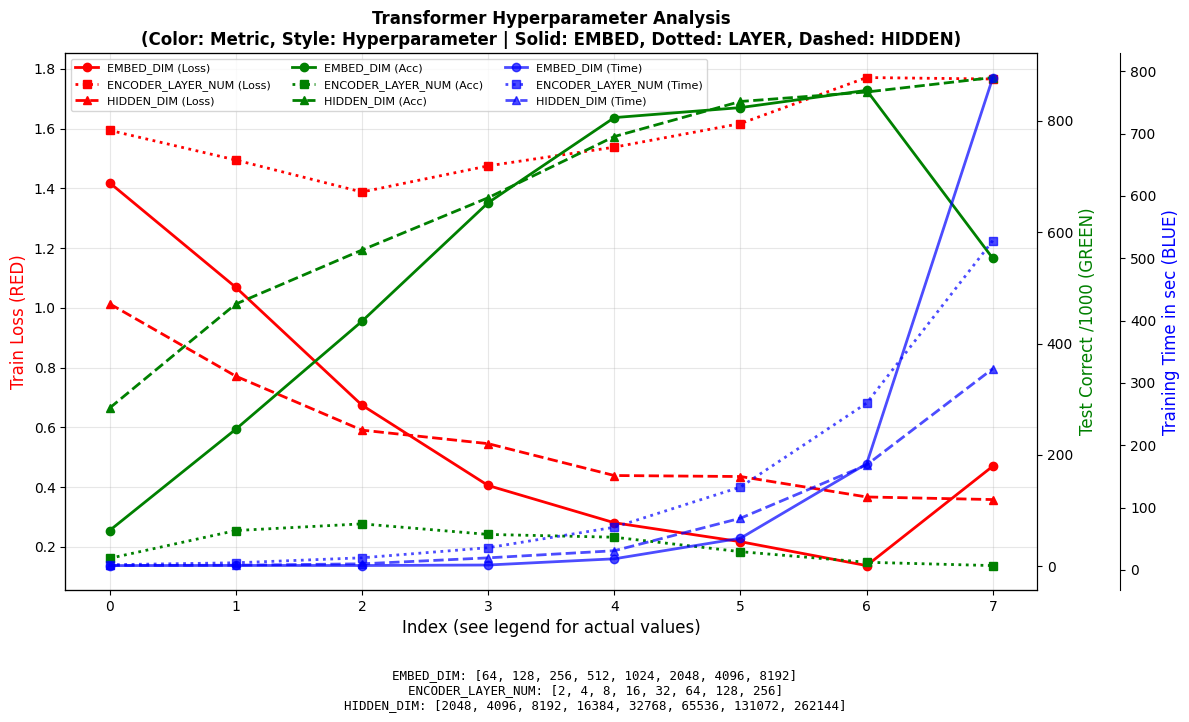

In [3]:
# ============================================================
# Plotting - Single Figure with 3 y-axes
# ============================================================
fig, ax1 = plt.subplots(figsize=(12, 7))

# Create additional y-axes
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

# X-axis: use indices (0 to n-1)
n = len(embed_dims)
x_indices = list(range(n))

# Plot Train Loss (RED) - Left y-axis
# Solid: EMBED_DIM, Dotted: ENCODER_LAYER_NUM, Dashed: HIDDEN_DIM
l1 = ax1.plot(x_indices, losses_embed, 'r-o', linewidth=2, markersize=6, label='EMBED_DIM (Loss)')
l2 = ax1.plot(x_indices, losses_encoder, 'r:s', linewidth=2, markersize=6, label='ENCODER_LAYER_NUM (Loss)')
l3 = ax1.plot(x_indices, losses_hidden, 'r--^', linewidth=2, markersize=6, label='HIDDEN_DIM (Loss)')

# Plot Test Accuracy (GREEN) - Right y-axis 1
l4 = ax2.plot(x_indices, accs_embed, 'g-o', linewidth=2, markersize=6, label='EMBED_DIM (Acc)')
l5 = ax2.plot(x_indices, accs_encoder, 'g:s', linewidth=2, markersize=6, label='ENCODER_LAYER_NUM (Acc)')
l6 = ax2.plot(x_indices, accs_hidden, 'g--^', linewidth=2, markersize=6, label='HIDDEN_DIM (Acc)')

# Plot Training Time (BLUE) - Right y-axis 2
l7 = ax3.plot(x_indices, times_embed, 'b-o', linewidth=2, markersize=6, alpha=0.7, label='EMBED_DIM (Time)')
l8 = ax3.plot(x_indices, times_encoder, 'b:s', linewidth=2, markersize=6, alpha=0.7, label='ENCODER_LAYER_NUM (Time)')
l9 = ax3.plot(x_indices, times_hidden, 'b--^', linewidth=2, markersize=6, alpha=0.7, label='HIDDEN_DIM (Time)')

# Labels
ax1.set_xlabel('Index (see legend for actual values)', fontsize=12)
ax1.set_ylabel('Train Loss (RED)', fontsize=12, color='red')
ax2.set_ylabel('Test Correct /1000 (GREEN)', fontsize=12, color='green')
ax3.set_ylabel('Training Time in sec (BLUE)', fontsize=12, color='blue')

# Set x-axis ticks
ax1.set_xticks(x_indices)
ax1.set_xticklabels([f'{i}' for i in x_indices])

# Add text annotation for actual values
embed_str   = f"EMBED_DIM: {embed_dims}"
encoder_str = f"ENCODER_LAYER_NUM: {encoder_layers}"
hidden_str  = f"HIDDEN_DIM: {hidden_dims}"
fig.text(0.5, -0.02, f"{embed_str}\n{encoder_str}\n{hidden_str}", 
         ha='center', fontsize=9, family='monospace')

# Combine legends
lines  = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=8, ncol=3)

ax1.grid(True, alpha=0.3)
plt.title('Transformer Hyperparameter Analysis\n(Color: Metric, Style: Hyperparameter | Solid: EMBED, Dotted: LAYER, Dashed: HIDDEN)', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## 3.2. SOTA model analysis

In [3]:
import time
import numpy as np

# ============================================================
# Exhaustive Evaluation: All 10000 cases
# ============================================================

# Load Transformer SOTA
model = MyTransformer(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, ENCODER_LAYER_NUM).to(DEVICE)
model.load_state_dict(torch.load('model/transformer_sota.pth'))
model.eval()
print("Transformer SOTA model loaded.")


model.eval()

x_values      = []  # num1 * 100 + num2 (0 ~ 9999)
y_values      = []  # deviation (true - pred)
true_labels   = []
pred_labels   = []

start_time = time.time()

with torch.no_grad():
    for num11 in tq(range(10), desc="Exhaustive Test"):
        for num12 in range(10):
            for num21 in range(10):
                for num22 in range(10):
                    # Create input
                    num1 = num11 * 10 + num12
                    num2 = num21 * 10 + num22
                    true_sum = num1 + num2
                    
                    # Prepare input tensor
                    src = torch.tensor([[num11, num12, num21, num22]], dtype=torch.long).to(DEVICE)
                    
                    # Predict
                    logits = model(src)
                    preds  = logits.argmax(-1)  # (1, 3)
                    
                    # Convert prediction to number
                    pred_digits = preds[0].cpu().tolist()
                    pred_sum    = pred_digits[0] * 100 + pred_digits[1] * 10 + pred_digits[2]
                    
                    # Store results
                    x_values.append(num1 * 100 + num2)  # 0 ~ 9999
                    y_values.append(true_sum - pred_sum)  # deviation
                    true_labels.append(true_sum)
                    pred_labels.append(pred_sum)

total_time = time.time() - start_time

# ============================================================
# Calculate Metrics
# ============================================================
x_values    = np.array(x_values)
y_values    = np.array(y_values)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Correct predictions
correct = np.sum(y_values == 0)
total   = len(y_values)

# Precision & Recall
precision = correct / total if total > 0 else 0
recall    = correct / total if total > 0 else 0

# Deviation statistics
dev_mean = np.mean(y_values)
dev_std  = np.std(y_values)

print("\n" + "=" * 60)
print("SOTA Transformer Model - Exhaustive Test Results")
print("=" * 60)
print(f"Total computation time:    {total_time:.4f} seconds")
print(f"Time per iteration:        {total_time / total * 1000:.4f} ms")
print(f"Precision:                 {precision * 100:.2f}% ({correct}/{total})")
print(f"Recall:                    {recall * 100:.2f}%")
print(f"Deviation mean:            {dev_mean:.4f}")
print(f"Deviation std:             {dev_std:.4f}")
print("=" * 60)

Transformer SOTA model loaded.


Exhaustive Test: 100%|██████████| 10/10 [01:10<00:00,  7.07s/it]


SOTA Transformer Model - Exhaustive Test Results
Total computation time:    70.7286 seconds
Time per iteration:        7.0729 ms
Precision:                 82.21% (8221/10000)
Recall:                    82.21%
Deviation mean:            -0.5869
Deviation std:             13.5519


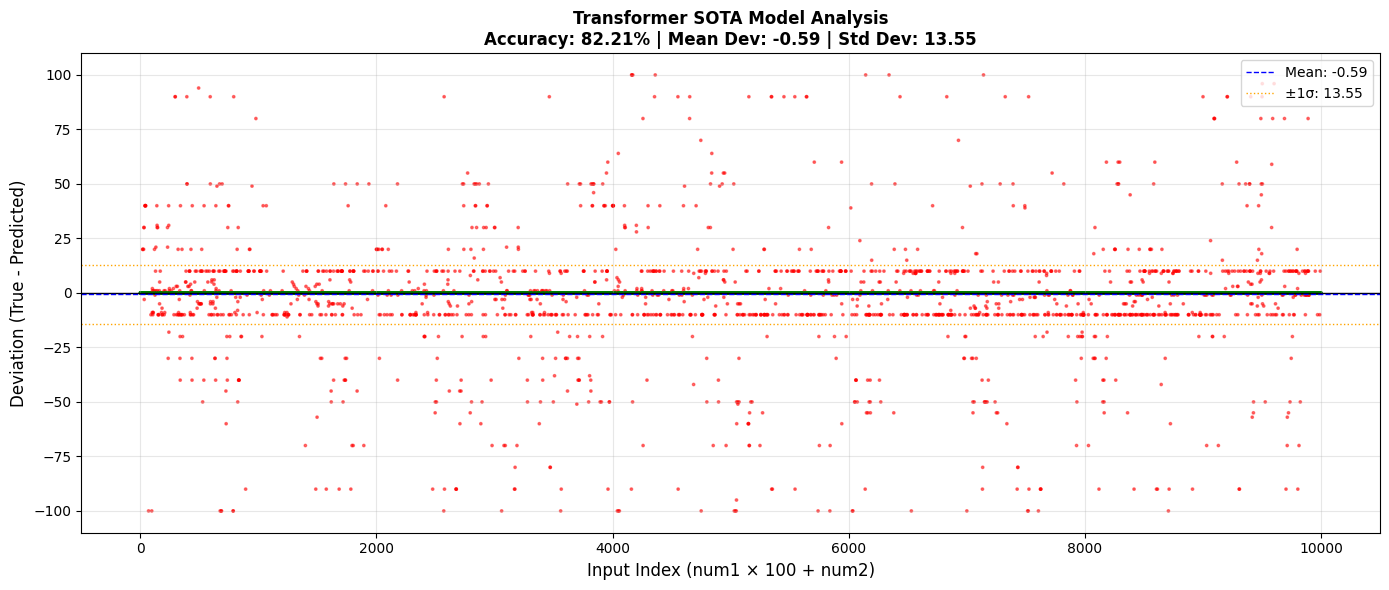


Sample Error Cases (first 10):
--------------------------------------------------
 0 + 20 =  20 | Pred:   0 | Dev:  +20
 0 + 21 =  21 | Pred:   1 | Dev:  +20
 0 + 28 =  28 | Pred:   8 | Dev:  +20
 0 + 30 =  30 | Pred:   0 | Dev:  +30
 0 + 32 =  32 | Pred:   2 | Dev:  +30
 0 + 33 =  33 | Pred:  36 | Dev:   -3
 0 + 40 =  40 | Pred:   0 | Dev:  +40
 0 + 41 =  41 | Pred:   1 | Dev:  +40
 0 + 42 =  42 | Pred:   2 | Dev:  +40
 0 + 44 =  44 | Pred:   4 | Dev:  +40


In [4]:
import matplotlib.pyplot as plt

# ============================================================
# Plotting
# ============================================================
fig, ax = plt.subplots(figsize=(14, 6))

# Scatter plot: x = num1*100 + num2 (0~9999), y = deviation
colors = ['green' if d == 0 else 'red' for d in y_values]
ax.scatter(x_values, y_values, c=colors, alpha=0.5, s=3)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=dev_mean, color='blue', linestyle='--', linewidth=1, label=f'Mean: {dev_mean:.2f}')
ax.axhline(y=dev_mean + dev_std, color='orange', linestyle=':', linewidth=1, label=f'±1σ: {dev_std:.2f}')
ax.axhline(y=dev_mean - dev_std, color='orange', linestyle=':', linewidth=1)

ax.set_xlabel('Input Index (num1 × 100 + num2)', fontsize=12)
ax.set_ylabel('Deviation (True - Predicted)', fontsize=12)
ax.set_title(f'Transformer SOTA Model Analysis\nAccuracy: {precision*100:.2f}% | Mean Dev: {dev_mean:.2f} | Std Dev: {dev_std:.2f}', 
             fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show some error examples
print("\nSample Error Cases (first 10):")
print("-" * 50)
error_indices = np.where(y_values != 0)[0][:10]
for idx in error_indices:
    num1 = x_values[idx] // 100
    num2 = x_values[idx] % 100
    print(f"{num1:2d} + {num2:2d} = {true_labels[idx]:3d} | Pred: {pred_labels[idx]:3d} | Dev: {y_values[idx]:+4d}")


## 3.2. Transformer vs CNN SOTA model analysis

In [6]:
import time
import numpy as np

# ============================================================
# Load Both SOTA Models
# ============================================================

# Load Transformer SOTA
transformer_model = MyTransformer(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, ENCODER_LAYER_NUM).to(DEVICE)
transformer_model.load_state_dict(torch.load('model/85%_transformer_4096_2_64.pth'))
transformer_model.eval()
print("Transformer SOTA model loaded.")

# For CNN, you need to define CNN hyperparameters (adjust as needed)
CNN_EMBED_DIM      = 4096  # Adjust to your CNN SOTA values
CNN_CONV_LAYER_NUM = 2
CNN_NUM_CHANNELS   = 64

# Need to import/define MyCNN if not already available
# Assuming MyCNN is defined or imported

cnn_model = MyCNN(VOCAB_SIZE, CNN_EMBED_DIM, CNN_NUM_CHANNELS, CNN_CONV_LAYER_NUM).to(DEVICE)
cnn_model.load_state_dict(torch.load('model/76%_cnn_4096_2_64.pth'))
cnn_model.eval()
print("CNN SOTA model loaded.")

# ============================================================
# Exhaustive Evaluation: All 10000 cases for both models
# ============================================================

transformer_deviations = []
cnn_deviations         = []

start_time = time.time()

with torch.no_grad():
    for num11 in tq(range(10), desc="Exhaustive Test"):
        for num12 in range(10):
            for num21 in range(10):
                for num22 in range(10):
                    # Create input
                    num1     = num11 * 10 + num12
                    num2     = num21 * 10 + num22
                    true_sum = num1 + num2
                    
                    # Prepare input tensor
                    src = torch.tensor([[num11, num12, num21, num22]], dtype=torch.long).to(DEVICE)
                    
                    # Transformer prediction
                    logits_t     = transformer_model(src)
                    preds_t      = logits_t.argmax(-1)[0].cpu().tolist()
                    pred_sum_t   = preds_t[0] * 100 + preds_t[1] * 10 + preds_t[2]
                    transformer_deviations.append(true_sum - pred_sum_t)
                    
                    # CNN prediction
                    logits_c     = cnn_model(src)
                    preds_c      = logits_c.argmax(-1)[0].cpu().tolist()
                    pred_sum_c   = preds_c[0] * 100 + preds_c[1] * 10 + preds_c[2]
                    cnn_deviations.append(true_sum - pred_sum_c)

total_time = time.time() - start_time

transformer_deviations = np.array(transformer_deviations)
cnn_deviations         = np.array(cnn_deviations)

# ============================================================
# Calculate Metrics
# ============================================================
transformer_correct = np.sum(transformer_deviations == 0)
cnn_correct         = np.sum(cnn_deviations == 0)
total               = len(transformer_deviations)

print("\n" + "=" * 60)
print("SOTA Model Comparison - Exhaustive Test Results")
print("=" * 60)
print(f"Total computation time:    {total_time:.4f} seconds")
print(f"Time per iteration:        {total_time / total * 1000:.4f} ms")
print("-" * 60)
print(f"Transformer Accuracy:      {transformer_correct / total * 100:.2f}% ({transformer_correct}/{total})")
print(f"CNN Accuracy:              {cnn_correct / total * 100:.2f}% ({cnn_correct}/{total})")
print("=" * 60)

Transformer SOTA model loaded.
CNN SOTA model loaded.


Exhaustive Test: 100%|██████████| 10/10 [05:54<00:00, 35.47s/it]


SOTA Model Comparison - Exhaustive Test Results
Total computation time:    354.6828 seconds
Time per iteration:        35.4683 ms
------------------------------------------------------------
Transformer Accuracy:      84.48% (8448/10000)
CNN Accuracy:              78.49% (7849/10000)


/var/folders/fg/w98q2k8d1w31xss_6xdh683h0000gn/T/ipykernel_51804/761147154.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([transformer_deviations, cnn_deviations],


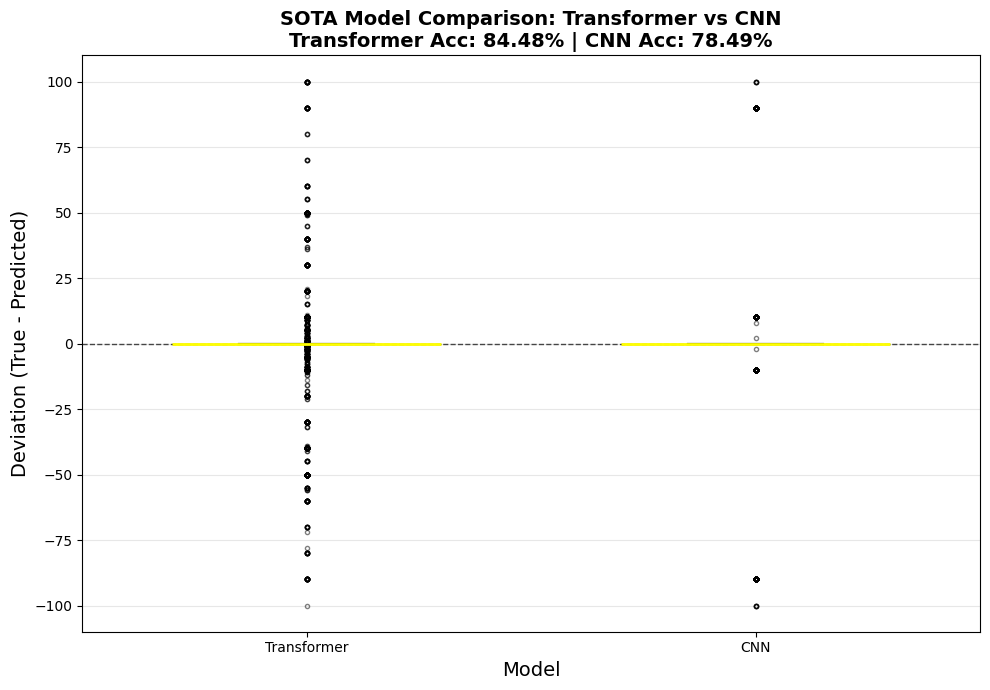

In [8]:
import matplotlib.pyplot as plt

# ============================================================
# Box Plot Comparison
# ============================================================
fig, ax = plt.subplots(figsize=(10, 7))

# Create box plot
bp = ax.boxplot([transformer_deviations, cnn_deviations], 
                labels=['Transformer', 'CNN'],
                patch_artist=True,
                widths=0.6)

# Set colors: Transformer = Red, CNN = Blue
colors = ['red', 'blue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# Style whiskers, caps, medians
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1.5)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1.5)
for median in bp['medians']:
    median.set(color='yellow', linewidth=2)
for flier in bp['fliers']:
    flier.set(marker='o', markersize=3, alpha=0.5)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Deviation (True - Predicted)', fontsize=14)
ax.set_title(f'SOTA Model Comparison: Transformer vs CNN\n'
             f'Transformer Acc: {transformer_correct/total*100:.2f}% | CNN Acc: {cnn_correct/total*100:.2f}%', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3.3. Transformer vs CNN loss comparison

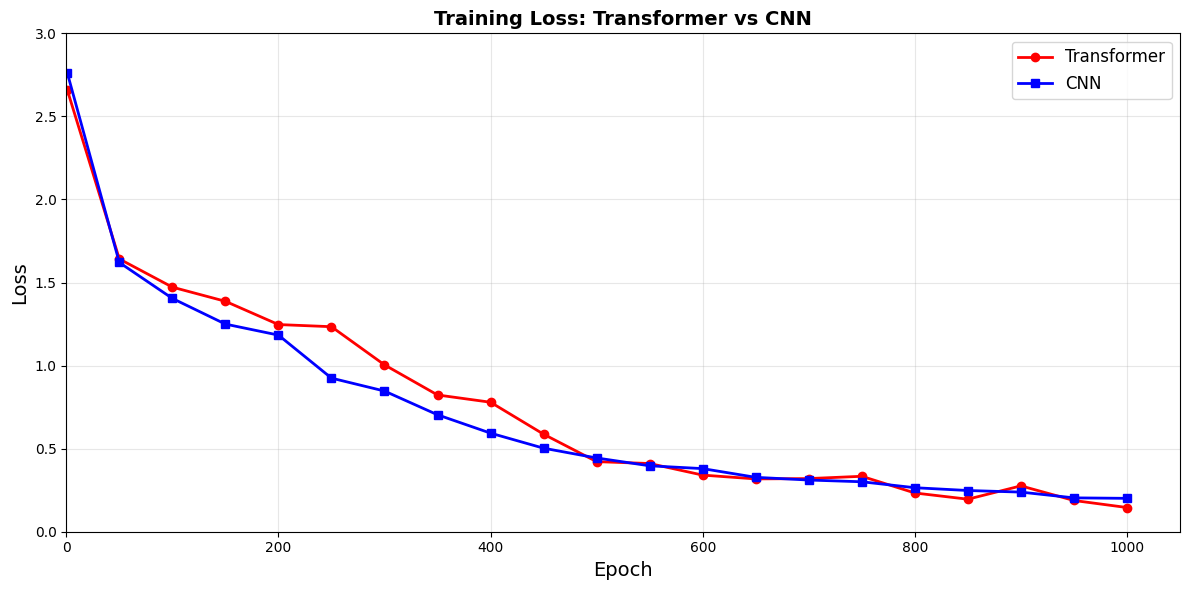

In [10]:
import matplotlib.pyplot as plt

# Transformer loss data (epochs, loss)
transformer_epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
transformer_loss   = [2.6582, 1.6419, 1.4722, 1.3870, 1.2470, 1.2341, 1.0044, 0.8232, 0.7794, 0.5870, 0.4219, 0.4105, 0.3408, 0.3179, 0.3199, 0.3337, 0.2332, 0.1958, 0.2760, 0.1880, 0.1457]

# CNN loss data (epochs, loss)
cnn_epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
cnn_loss   = [2.7611, 1.6207, 1.4044, 1.2498, 1.1835, 0.9246, 0.8468, 0.7039, 0.5934, 0.5028, 0.4440, 0.3968, 0.3799, 0.3274, 0.3111, 0.3007, 0.2649, 0.2481, 0.2385, 0.2038, 0.2009]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(transformer_epochs, transformer_loss, 'r-o', linewidth=2, markersize=6, label='Transformer')
ax.plot(cnn_epochs, cnn_loss, 'b-s', linewidth=2, markersize=6, label='CNN')

ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.set_title('Training Loss: Transformer vs CNN', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)

ax.set_xlim(0, 1050)
ax.set_ylim(0, 3)

plt.tight_layout()
plt.show()

## 3.4. frequent deviations

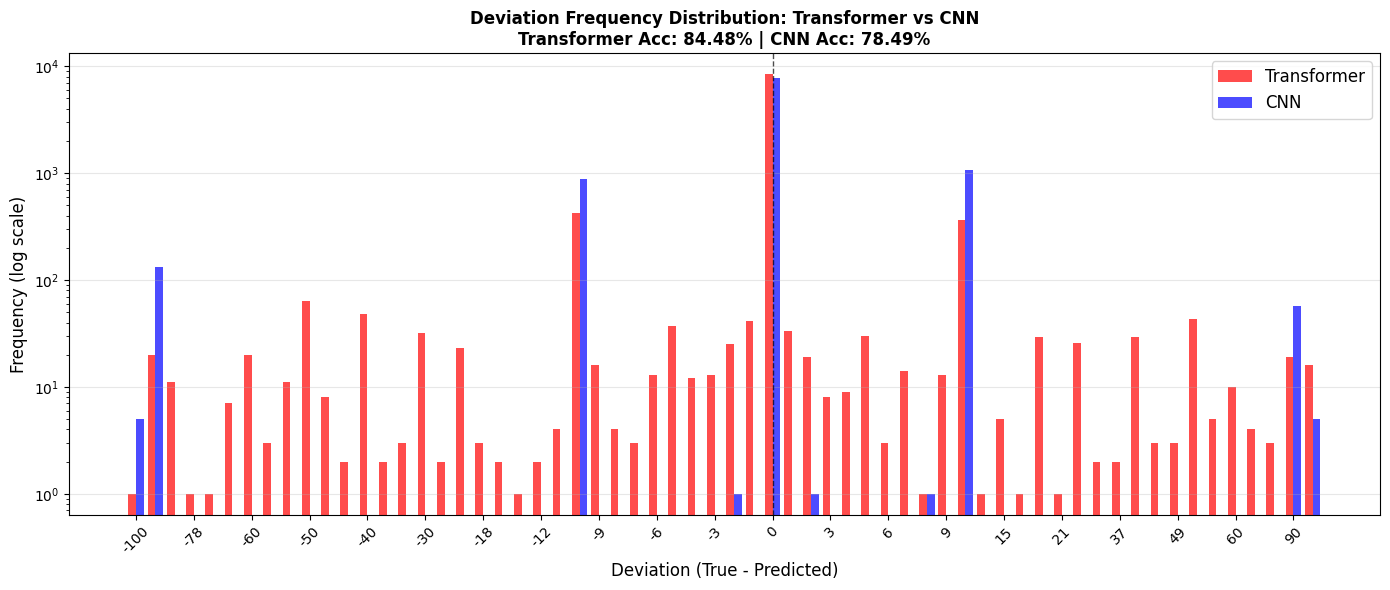


Top 5 Most Frequent Deviations:
--------------------------------------------------
Transformer:
  Deviation   +0:  8448 (84.48%)
  Deviation  -10:   423 (4.23%)
  Deviation  +10:   363 (3.63%)
  Deviation  -50:    63 (0.63%)
  Deviation  -40:    48 (0.48%)

CNN:
  Deviation   +0:  7849 (78.49%)
  Deviation  +10:  1070 (10.70%)
  Deviation  -10:   878 (8.78%)
  Deviation  -90:   133 (1.33%)
  Deviation  +90:    57 (0.57%)


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Count frequencies
transformer_counts = Counter(transformer_deviations)
cnn_counts         = Counter(cnn_deviations)

# Get all unique deviation values
all_deviations = sorted(set(transformer_deviations) | set(cnn_deviations))

# Get counts for each deviation value
transformer_freq = [transformer_counts.get(d, 0) for d in all_deviations]
cnn_freq         = [cnn_counts.get(d, 0) for d in all_deviations]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

width = 0.4
x = np.arange(len(all_deviations))

ax.bar(x - width/2, transformer_freq, width, color='red', alpha=0.7, label='Transformer')
ax.bar(x + width/2, cnn_freq, width, color='blue', alpha=0.7, label='CNN')

ax.set_yscale('log')
ax.set_xlabel('Deviation (True - Predicted)', fontsize=12)
ax.set_ylabel('Frequency (log scale)', fontsize=12)
ax.set_title(f'Deviation Frequency Distribution: Transformer vs CNN\n'
             f'Transformer Acc: {transformer_correct/total*100:.2f}% | CNN Acc: {cnn_correct/total*100:.2f}%',
             fontsize=12, fontweight='bold')

# Set x-ticks (show every 10th label if too many)
if len(all_deviations) > 30:
    step = max(1, len(all_deviations) // 20)
    ax.set_xticks(x[::step])
    ax.set_xticklabels([str(d) for d in all_deviations[::step]], rotation=45)
else:
    ax.set_xticks(x)
    ax.set_xticklabels([str(d) for d in all_deviations], rotation=45)

ax.axvline(x=list(all_deviations).index(0) if 0 in all_deviations else 0, 
           color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print top 5 most frequent deviations
print("\nTop 5 Most Frequent Deviations:")
print("-" * 50)
print("Transformer:")
for dev, count in transformer_counts.most_common(5):
    print(f"  Deviation {dev:+4d}: {count:5d} ({count/total*100:.2f}%)")
print("\nCNN:")
for dev, count in cnn_counts.most_common(5):
    print(f"  Deviation {dev:+4d}: {count:5d} ({count/total*100:.2f}%)")

# 4. Save the model.

In [6]:
import os

# Create directory if not exists
os.makedirs('model', exist_ok=True)

# Save Transformer SOTA model
torch.save(model.state_dict(), 'model/85%_transformer_4096_2_64.pth')
print("Transformer SOTA model saved to model/85%_transformer_4096_2_64.pth")

Transformer SOTA model saved to model/85%_transformer_4096_2_64.pth




# 1. CNN Define.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm as tq


DIGITS     = ['0','1','2','3','4','5','6','7','8','9']
VOCAB_SIZE = len(DIGITS)
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Fixed hyperparameters
INPUT_LEN     = 4
OUTPUT_LEN    = 3
LEARNING_RATE = 1e-4
NUM_EPOCH     = 1000
BATCH_SIZE    = 128

# Changable hyperparameters
EMBED_DIM      = 1024
CONV_LAYER_NUM = 16 
NUM_CHANNELS   = 32

char_to_idx = {c: i for i, c in enumerate(DIGITS)}
idx_to_char = {i: c for i, c in enumerate(DIGITS)}

# batch data generation
def generate_batch(batch_size=100):
    inputs, targets = [], []
    for _ in range(batch_size):
        tens1, ones1 = random.randint(0, 9), random.randint(0, 9)
        tens2, ones2 = random.randint(0, 9), random.randint(0, 9)
        num1, num2 = tens1 * 10 + ones1, tens2 * 10 + ones2
        s = num1 + num2
        inputs.append([tens1, ones1, tens2, ones2])
        sum_str = f"{s:03d}"
        targets.append([char_to_idx[c] for c in sum_str])
    return (torch.tensor(inputs, dtype=torch.long).to(DEVICE),
            torch.tensor(targets, dtype=torch.long).to(DEVICE))

# ReLU
def my_relu(x):
    return torch.clamp(x, min=0.0)

#------------------------------------
# 4 digits to one-hot vectors
#------------------------------------
def MyOneHot(x, vocab_size):    
    B, L = x.size()     # batch size x INPUT_LEN

    ############################################################################
    # TODO: Convert x to one-hot
    ############################################################################

    # Create zero tensor of shape (B, L, vocab_size)
    out = torch.zeros(B, L, vocab_size, device=x.device)
    # Use scatter to fill in the one-hot encoding
    out.scatter_(2, x.unsqueeze(2), 1.0)

    ############################################################################
    # END TODO
    ############################################################################

    return out   # B x L x vocab_size

#------------------------------------
# Embedding layer
#------------------------------------
class MyEmbedding(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(vocab_size, dim) * 0.1)

    def forward(self, x):
        B, L = x.size()

        ############################################################################
        # TODO: Convert x to one-hot and then embedding
        #    Use MyOneHot() function above
        ############################################################################

        # Convert to one-hot: (B, L, vocab_size)
        one_hot = MyOneHot(x, self.weight.size(0))
        # Matrix multiply with embedding weight: (B, L, vocab_size) @ (vocab_size, dim) = (B, L, dim)
        out = torch.matmul(one_hot, self.weight)
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x L x dim

#------------------------------------
# Linear layer
#------------------------------------
class MyLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * 0.1)
        self.bias   = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):

        ############################################################################
        # TODO: Compute linear layer output
        #   You should implement your own linear layer operation.
        ############################################################################
            
        # x: (..., in_dim), weight: (out_dim, in_dim), bias: (out_dim)
        # out = x @ W^T + bias
        out = torch.matmul(x, self.weight.t()) + self.bias
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  

#------------------------------------
# Conv layer
#------------------------------------
class MyConv2D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1):
        super().__init__()

        self.in_channel  = in_channel
        self.out_channel = out_channel
        self.kernel      = kernel_size
        self.pad         = padding
        
        self.weight = nn.Parameter(torch.randn(out_channel, in_channel, kernel_size, kernel_size) * 0.1)
        self.bias   = nn.Parameter(torch.zeros(out_channel))

    def forward(self, x):
        B, C, H, W = x.shape

        ############################################################################
        # TODO: 2D convolution operation
        #   You should implement your own convolution operation.
        ############################################################################

        # Pad the input
        if self.pad > 0:
            x_padded = torch.zeros(B, C, H + 2 * self.pad, W + 2 * self.pad, device=x.device)
            x_padded[:, :, self.pad:self.pad + H, self.pad:self.pad + W] = x
        else:
            x_padded = x
        
        H_pad, W_pad = x_padded.shape[2], x_padded.shape[3]
        
        # Output dimensions (stride=1)
        H_out = H_pad - self.kernel + 1
        W_out = W_pad - self.kernel + 1
        
        # Initialize output
        out = torch.zeros(B, self.out_channel, H_out, W_out, device=x.device)
        
        # Perform convolution
        for i in range(H_out):
            for j in range(W_out):
                # Extract patch: (B, C, kernel, kernel)
                patch = x_padded[:, :, i:i + self.kernel, j:j + self.kernel]
                # patch: (B, in_channel, kernel, kernel)
                # weight: (out_channel, in_channel, kernel, kernel)
                # Compute convolution for all output channels at once
                for oc in range(self.out_channel):
                    # Sum over in_channel, kernel_h, kernel_w
                    out[:, oc, i, j] = (patch * self.weight[oc]).sum(dim=(1, 2, 3)) + self.bias[oc]

        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x out_ch x H x W

#------------------------------------
# CNN model
#------------------------------------
class MyCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_channels, num_conv_layers):
        super().__init__()

        ############################################################################
        # TODO: Define each layer (embedding, conv1, conv2, ..., fc)
        #     Use MyEmbedding, MyConv2D, MyLinear classes defined above.
        ############################################################################
        
        self.embed_dim       = embed_dim
        self.num_channels    = num_channels
        self.num_conv_layers = num_conv_layers
        
        # Embedding layer
        self.embedding = MyEmbedding(vocab_size, embed_dim)
        
        # Conv layers using nn.ModuleList for dynamic number of layers
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            if i == 0:
                # First conv: in_channel = embed_dim, out_channel = num_channels
                self.conv_layers.append(MyConv2D(embed_dim, num_channels, kernel_size=3, padding=1))
            else:
                # Subsequent convs: in_channel = num_channels, out_channel = num_channels
                self.conv_layers.append(MyConv2D(num_channels, num_channels, kernel_size=3, padding=1))
        
        # FC layer: input is flattened conv output (2 * 2 * num_channels), output is 3 * VOCAB_SIZE
        self.fc = MyLinear(2 * 2 * num_channels, OUTPUT_LEN * vocab_size)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):
        B = x.size(0)

        ############################################################################
        # TODO: Define forward path: 
        #    embedding -> reshape -> conv1 -> ReLU -> conv2 -> ReLU -> ... -> flatten -> fc
        ############################################################################

        # Embedding: (B, 4) -> (B, 4, embed_dim)
        out = self.embedding(x)

        # Reshape to image-like: (B, 4, embed_dim) -> (B, embed_dim, 2, 2)
        out = out.permute(0, 2, 1)  # (B, embed_dim, 4)
        out = out.view(B, self.embed_dim, 2, 2)  # (B, embed_dim, 2, 2)
        
        # Apply conv layers with ReLU
        for conv in self.conv_layers:
            out = conv(out)  # (B, num_channels, 2, 2)
            out = my_relu(out)
        
        # Flatten
        out = out.view(B, -1)  # (B, 2*2*num_channels)
        
        # FC layer
        out = self.fc(out)  # (B, 3*VOCAB_SIZE)
        
        # Reshape to (B, 3, VOCAB_SIZE)
        out = out.view(B, OUTPUT_LEN, VOCAB_SIZE)

        ############################################################################
        # END TODO
        ############################################################################

        return out    # B x 3 x VOCAB_SIZE

